<a href="https://colab.research.google.com/github/anh1811/baocao/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
import tensorflow as tf
import numpy as np
import scipy.optimize as opt

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
x_train = x_train.reshape(x_train.shape[0],-1)
y_train = y_train
x_val = x_test[0:5000].reshape(5000,-1)
y_val = y_test[0:5000]
x_test = x_test[5000:10000].reshape(5000,-1)
y_test = y_test[5000:10000]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def sigmoid(x):
  return 1/(1+np.exp(-x));
def sigmoidGradient(x):
  return sigmoid(x)*(1-sigmoid(x))

In [ ]:
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda):
  Theta1 = np.reshape(nn_params[0:hidden_layer_size * (input_layer_size + 1)],\
                          [hidden_layer_size, (input_layer_size + 1)])
  Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):],\
                          [num_labels, (hidden_layer_size + 1)])
  m = X.shape[0];
  I = np.eye(num_labels)
  X = np.concatenate((np.ones((m,1)),X),1) 
  z2 = np.dot(X,Theta1.T) 
  a2 = sigmoid(z2)
  a2 = np.concatenate((np.ones((m,1)),a2),1) 
  z3 = np.dot(a2,Theta2.T) 
  a3 = sigmoid(z3)
  J = 0
  Theta1_grad = np.zeros((hidden_layer_size,input_layer_size+1))
  Theta2_grad = np.zeros((num_labels,hidden_layer_size+1))
  for i in range(0,m):
    if np.isscalar(y):
      yi = I[int(y)]
    else:
      yi = I[int(y[i])] 
    J += (-np.dot(np.log10(a3[i,:]),yi) - np.log10((1 - a3[i,:])) @ (1 -yi)) * 1/m
    delta3 = a3[i,:] - yi
    delta2 = np.dot(Theta2.T,delta3) * sigmoidGradient(np.append(1,z2[i,:])) 
    delta2 = delta2[1:] 
    Theta1_grad += np.dot(delta2[:,np.newaxis],X[i,:][np.newaxis,:])
    Theta2_grad += np.dot(delta3.reshape(num_labels,1),a2[i,:].reshape(1,hidden_layer_size + 1))
  J += Lambda/(2*m)*(np.sum(Theta1[0:,1:]**2) + np.sum(Theta2[0:,1:]**2))
  Theta1_grad = Theta1_grad/m 
  Theta1_grad[0:,1:] += Lambda/m * Theta1[0:,1:]
  Theta2_grad = Theta2_grad/m 
  Theta2_grad[0:,1:] += Lambda/m * Theta2[0:,1:]

  grad = np.append(Theta1_grad, Theta2_grad)
  return [J,grad]



def randInitializeWeights(L_in, L_out):
  epsilon_init = np.sqrt(6)/np.sqrt(L_in+L_out)
  W = np.random.random((L_out, 1+L_in))*(2*epsilon_init) - epsilon_init
  return W

def featureNormalize(X):
  mu = np.mean(X,axis =0)
  X_norm = X-mu
  sigma = np.std(X_norm,axis =0, ddof=1)
  sigma_1 = np.where(sigma==0,1,sigma)
  X_norm = X_norm/sigma_1
  return X_norm, mu, sigma

def predict(Theta1, Theta2, X):

  m = X.shape[0];
  num_labels = Theta2.shape[0];

  h1 = sigmoid(np.concatenate((np.ones((m,1)),X),1) @ Theta1.T)
  h2 = sigmoid(np.concatenate((np.ones((m,1)),h1),1) @ Theta2.T)

  p = np.argmax(h2,axis=1)

  return p

def pca(X):
  m = X.shape[0];
  Sigma = (1/m)*np.dot(X.T,X)
  U, S, Vh = np.linalg.svd(Sigma)
  return (U,S)

def projectData(X, U, K):
  Ureduce = U[:,0:K]
  Z = np.dot(X,Ureduce)
  return Z

   

In [ ]:
x_train, mu_train, sigma_train = featureNormalize(x_train)
x_test, mu_test, sigma_test =featureNormalize(x_test)
x_val, mu_val, sigma_val = featureNormalize(x_val)
print("Normalize Data! Done!")

Normalize Data! Done!


In [ ]:
K = 1
var = 0
U,S = pca(x_train)
S_sum = S.sum() 
while(var < 0.95):
  var = S[0:K].sum()/S_sum
  K += 1
print("Dimensional reuduction: K = {}".format(K)) 

Dimensional reuduction: K = 332


In [ ]:
# Found from above algorithm
x_train = projectData(x_train, U, K)
x_test = projectData(x_test,U,K)
x_val = projectData(x_val,U,K)

In [ ]:
input_layer_size  = K
hidden_layer_size = 64
num_labels = 10


print('\nInitializing Neural Network Parameters ...\n')

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
initial_nn_params = np.append(initial_Theta1,initial_Theta2)
print('Initializing Neural Network Parameters! Done!\n')

m = x_train.shape[0]
Lambda_vec = [0.001, 0.003, 0.01, 0.03, 0.3,1, 3]
Lambda_vec_len = len(Lambda_vec)
val_result_max =0 #Will be changed later


Initializing Neural Network Parameters ...

Initializing Neural Network Parameters! Done!



In [ ]:
# stochaic gradient descent
# chon Lambda = 0.001
J_array = []
J_mean = []
nn_params = initial_nn_params.copy()
X = np.concatenate((x_train,y_train[:,np.newaxis]), 1)
np.random.shuffle(X)
x_train = X[:,:-1]
y_train = X[:,-1]
num_iter = 0
for j in range(1):
  for i in range(m):
    J,grad = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels,\
                            x_train[i,:][np.newaxis,:], y_train[i], 0.001)
    J_array.append(J)
    num_iter += 1
    if num_iter % 1000 == 0:
        J_mean.append(np.array(J_array).mean())
        J_array = []
    nn_params -= 0.01*grad

num_iter = [i * 1000 for i in range(len(J_mean))]

Theta1 = np.reshape(nn_params[0:hidden_layer_size * (input_layer_size + 1)],\
                           [hidden_layer_size, (input_layer_size + 1)])
Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):],\
                           [num_labels, (hidden_layer_size + 1)])
pred_val = predict(Theta1, Theta2, x_val);
val_result = (np.mean(pred_val==y_val) * 100)
print(f"The accuracy on validate set is about {val_result}%\n")

The accuracy on validate set is about 91.58%



In [ ]:
# mini-batch gradient descent
# Chon lambda = 0.001
nn_params = initial_nn_params.copy()
X = np.concatenate((x_train,y_train[:,np.newaxis]), 1)
np.random.shuffle(X)
x_train = X[:,:-1]
y_train = X[:,-1]
J_valarray = []
J_trainarray = []
for i in range(30):
  j = 0
  while j < m:
     J,grad = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels,\
                            x_train[j:j+100,:], y_train[j:j+100], 0.001)
     nn_params -= 0.1*grad
     j += 100
  J_train, grad_1 = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels,\
                            x_train, y_train, 0.001)
  J_val, grad_2 = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels,\
                            x_val, y_val, 0.001)
  J_trainarray.append(J_train)
  J_valarray.append(J_val)

num_iter = [i for i in range(30)]
Theta1 = np.reshape(nn_params[0:hidden_layer_size * (input_layer_size + 1)],\
                           [hidden_layer_size, (input_layer_size + 1)])
Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):],\
                           [num_labels, (hidden_layer_size + 1)])
pred_val = predict(Theta1, Theta2, x_val);
val_result = (np.mean(pred_val==y_val) * 100)
print(f"The accuracy on validate set is about {val_result}%\n")

In [ ]:
# batch gradient descent
# Chon lambda = 1
nn_params = initial_nn_params.copy()
num_iters = 30
for i in range(1):
  print(f"With Lambda = {Lambda_vec[5]}, {num_iters} iters")
  val_result =0

  result = opt.minimize(nnCostFunction, x0=initial_nn_params, args=(\
        input_layer_size, hidden_layer_size, num_labels, x_train, y_train, Lambda_vec[5])\
        ,method='L-BFGS-B',jac=True,options={'maxiter':num_iters})
      
  nn_params = result.x
  

  Theta1 = np.reshape(nn_params[0:hidden_layer_size * (input_layer_size + 1)],\
                          [hidden_layer_size, (input_layer_size + 1)])
  Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):],\
                          [num_labels, (hidden_layer_size + 1)])
  pred_val = predict(Theta1, Theta2, x_val);

  val_result = (np.mean(pred_val==y_val) * 100)
  print(np.mean(pred_val==y_val) * 100)


  if val_result > val_result_max:
    val_result_max = val_result
    Lambda = Lambda_vec[i]
    final_nn_params = nn_params


print(f"The accuracy on validate set is about {val_result}%\n")

With Lambda = 1, 30 iters
92.5
The accuracy on validate set is about 92.5%



In [ ]:
# J = np.save(r"/content/drive/MyDrive/MNIST problem",nn_params,allow_pickle = False)
nn_params = np.load(r"/content/drive/MyDrive/MNIST problem.npy")
Theta1 = np.reshape(nn_params[0:hidden_layer_size * (input_layer_size + 1)],\
                        [hidden_layer_size, (input_layer_size + 1)])
Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):],\
                        [num_labels, (hidden_layer_size + 1)])

In [ ]:
pred_train = predict(Theta1, Theta2, x_train);
print(f"The accuracy on train set is about {np.mean(pred_train==y_train) * 100}%")

pred_test = predict(Theta1, Theta2, x_test);
print(f"The accuracy on test set is about {np.mean(pred_test==y_test) * 100}%")

The accuracy on train set is about 96.87166666666667%
The accuracy on test set is about 97.26%


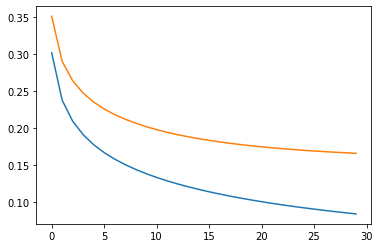

In [ ]:
import matplotlib.pyplot as plt
plt.plot(num_iter, J_trainarray)
plt.plot(num_iter, J_valarray)

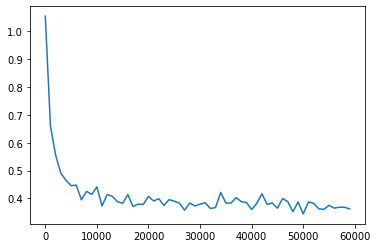

In [ ]:
plt.plot(num_iter, J_mean)